In [313]:
import pandas as pd
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy as sc
from statsmodels.graphics.regressionplots import plot_leverage_resid2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Прочитаем данные и посмотрим что они из себя представляют. 

In [314]:
data = pd.read_csv("data.txt", sep="\t")
data.columns = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","y"]
cols_x = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10"]
data.head()

x1        x2        x3        x4        x5        x6        x7  \
0  0.968379  0.716820  0.678846  0.510049  0.545299  0.573692  0.817491   
1  0.468263  0.405603  0.320325  0.468084  0.100995  0.974407  0.300062   
2  0.776820  0.103740  0.373748  0.797782  0.906810  0.599069  0.626680   
3  0.407886  0.415357  0.101543  0.935160  0.444124  0.193607  0.656837   
4  0.538797  0.088621  0.886119  0.781848  0.401623  0.207652  0.946310   

         x8        x9       x10   y  
0  0.206636  0.880111  0.574187  17  
1  0.608356  0.050082  0.762011  12  
2  0.924705  0.632768  0.512663  16  
3  0.599929  0.868582  0.405406  20  
4  0.769453  0.827292  0.937183  15

In [315]:
data.describe()

x1          x2          x3          x4          x5          x6  \
count  999.000000  999.000000  999.000000  999.000000  999.000000  999.000000   
mean     0.490827    0.499310    0.496888    0.503228    0.509042    0.513511   
std      0.293875    0.278568    0.297874    0.284238    0.283407    0.291201   
min      0.000188    0.000085    0.003110    0.001223    0.005314    0.000517   
25%      0.218936    0.262003    0.231736    0.268896    0.274559    0.255409   
50%      0.504846    0.500539    0.484541    0.503712    0.509213    0.527405   
75%      0.738493    0.733853    0.765198    0.747857    0.742668    0.767153   
max      0.999566    0.999959    0.998918    0.998785    0.998478    0.999059   

               x7          x8          x9         x10           y  
count  999.000000  999.000000  999.000000  999.000000  999.000000  
mean     0.487020    0.498947    0.505185    0.499138   15.014014  
std      0.288537    0.286087    0.282951    0.284215    4.773613  
min      0.000493    0.000408    0.007883    0.000170    3.000000  
25%      0.237670    0.256067    0.262155    0.249582   12.000000  
50%      0.474573    0.501866    0.518658    0.509578   15.000000  
75%      0.739001    0.737045    0.748219    0.742393   18.000000  
max      0.999179    0.998646    0.998884    0.998819   29.000000

#### Посмотрим на зависимости переменных друг от друга и соответствующие гистограммы

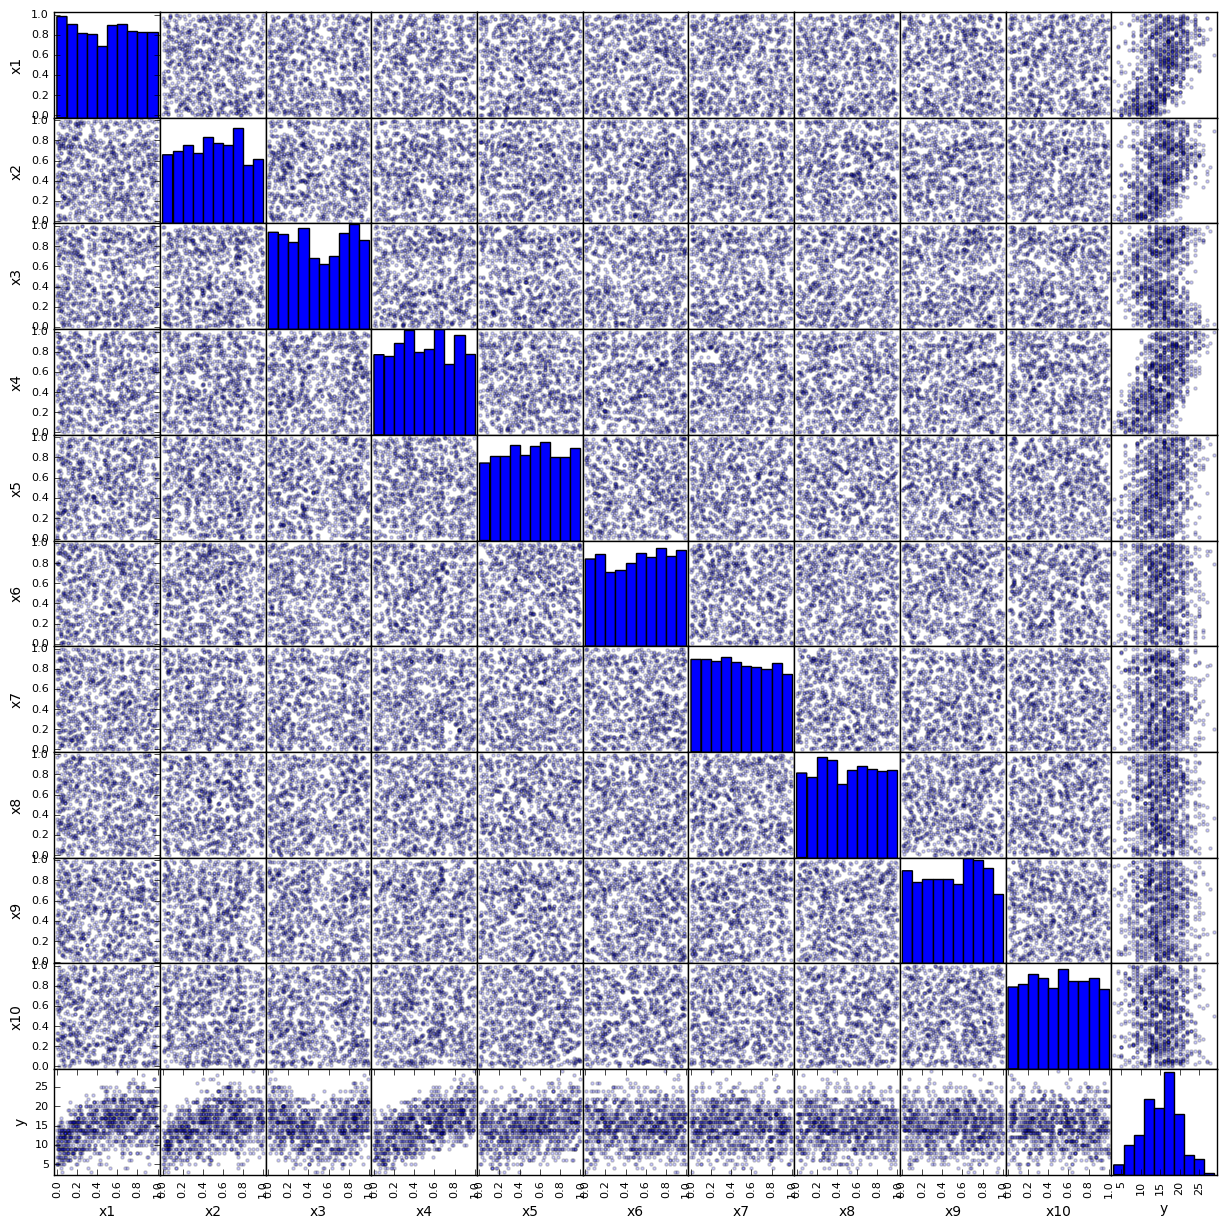

In [316]:
pd.tools.plotting.scatter_matrix(data, alpha=0.2, figsize=(15, 15), diagonal='hist')
pylab.show()

#### Гистограммы X'ов с первого взгляда похожи на равномерное распределение на [0,1], целевой переменной - на нормальное.

In [317]:
X.corr()

x1        x2        x3        x4        x5        x6        x7  \
x1   1.000000 -0.028951 -0.000165 -0.015693  0.006548 -0.014674 -0.032819   
x2  -0.028951  1.000000  0.003384  0.017135 -0.054426 -0.023654 -0.025272   
x3  -0.000165  0.003384  1.000000  0.030849 -0.038404  0.022170  0.017166   
x4  -0.015693  0.017135  0.030849  1.000000 -0.062427 -0.021443  0.003205   
x5   0.006548 -0.054426 -0.038404 -0.062427  1.000000  0.051943  0.024297   
x6  -0.014674 -0.023654  0.022170 -0.021443  0.051943  1.000000 -0.035583   
x7  -0.032819 -0.025272  0.017166  0.003205  0.024297 -0.035583  1.000000   
x8   0.007691  0.009242  0.060015 -0.012575  0.013156 -0.016187  0.012536   
x9  -0.011756  0.029460  0.013650  0.001645 -0.051975 -0.047277  0.102317   
x10 -0.007425 -0.050799  0.013423 -0.042897  0.017719 -0.014619  0.013930   

           x8        x9       x10  
x1   0.007691 -0.011756 -0.007425  
x2   0.009242  0.029460 -0.050799  
x3   0.060015  0.013650  0.013423  
x4  -0.012575  0.001645 -0.042897  
x5   0.013156 -0.051975  0.017719  
x6  -0.016187 -0.047277 -0.014619  
x7   0.012536  0.102317  0.013930  
x8   1.000000  0.004323  0.045053  
x9   0.004323  1.000000 -0.020574  
x10  0.045053 -0.020574  1.000000

#### Видно, что переменные X нескорреллированы между собой. Посмотрим, есть ли пустые (пропущенные) значения

In [318]:
# Проверка на пропущенные значения
pd.isnull(data).any(1).nonzero()[0]

array([], dtype=int64)

#### Пропущенных значений нет. Построим простейшую линейную модель регрессии на имеющиеся данные.

### Модель №1: Простейшая линейная модель.

In [319]:
model1 = smf.ols('y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10', 
             data=data)
fitted = model1.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     280.8
Date:                Thu, 16 Mar 2017   Prob (F-statistic):          1.22e-280
Time:                        21:53:56   Log-Likelihood:                -2306.2
No. Observations:                 999   AIC:                             4634.
Df Residuals:                     988   BIC:                             4688.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0061      0.441      2.280      0.0

####  Prob (F-statistic) = 1.22e-280 => Данная модель имеет хоть какой-то смысл и гипотеза о равенстве нулю всех коэффициентов перед иксами отвергается. Проверим остатки на гетероскедастичность тестом Бройша-Пагана.

In [320]:
print 'Breusch-Pagan test: p=%f' % sms.het_breushpagan(fitted.resid, fitted.model.exog)[1]

Breusch-Pagan test: p=0.000000


#### Ошибки гетероскедастичны, значит, значимость признаков может определяться неверно.

#### Построим QQ-график и распределение остатков

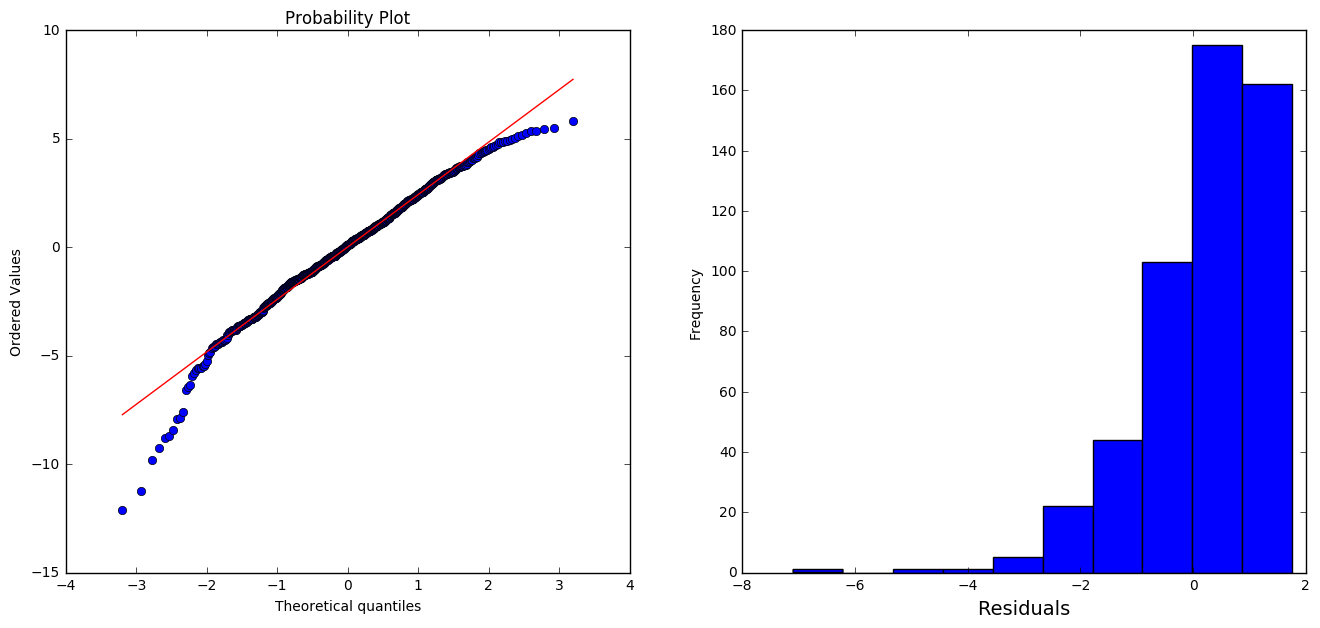

In [321]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

#### Видно, что распределение остатков ненормально, а нам бы очень хотелось иметь именно такое, чтобы интерпретировать данные

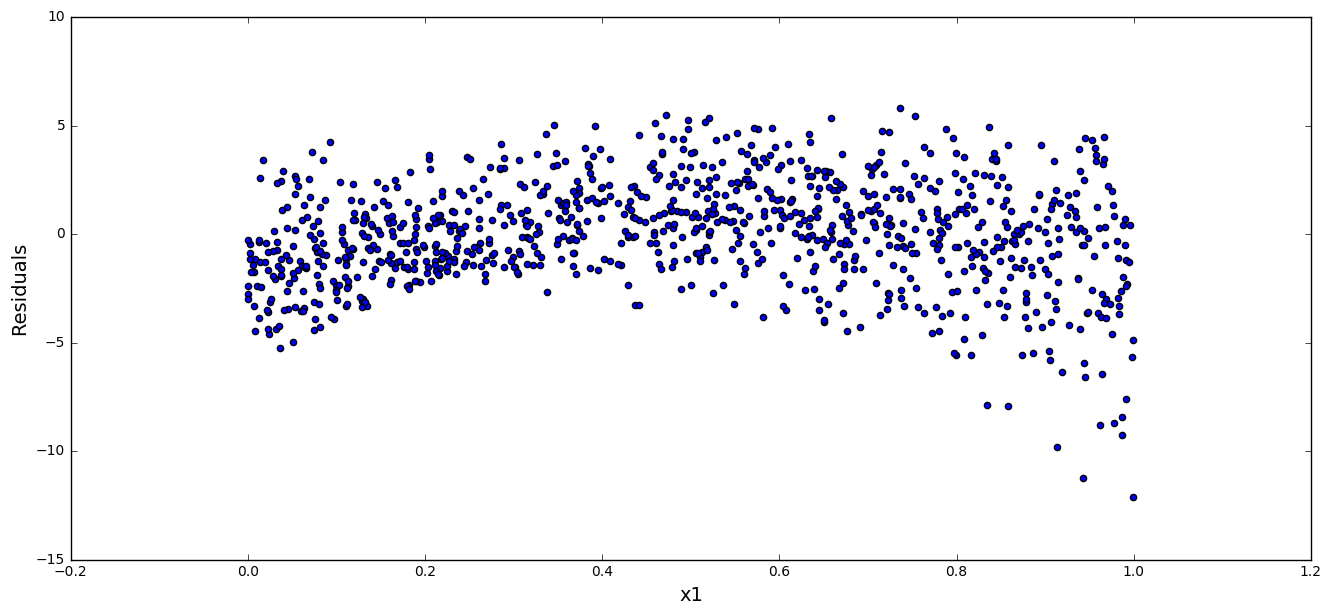

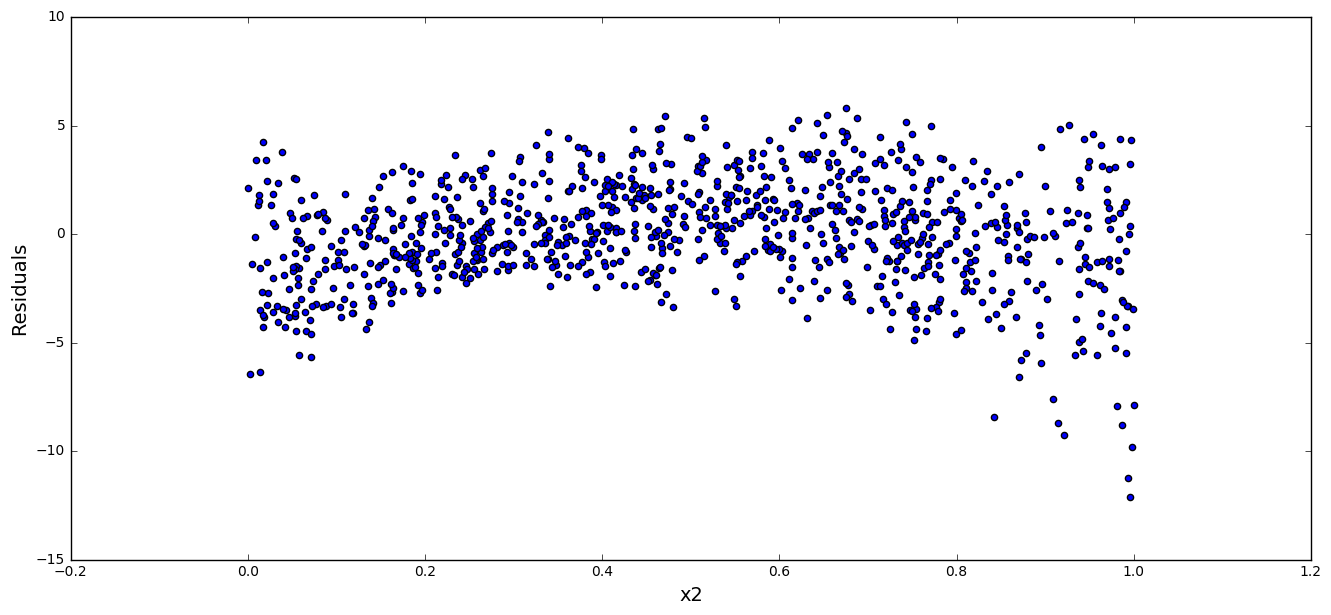

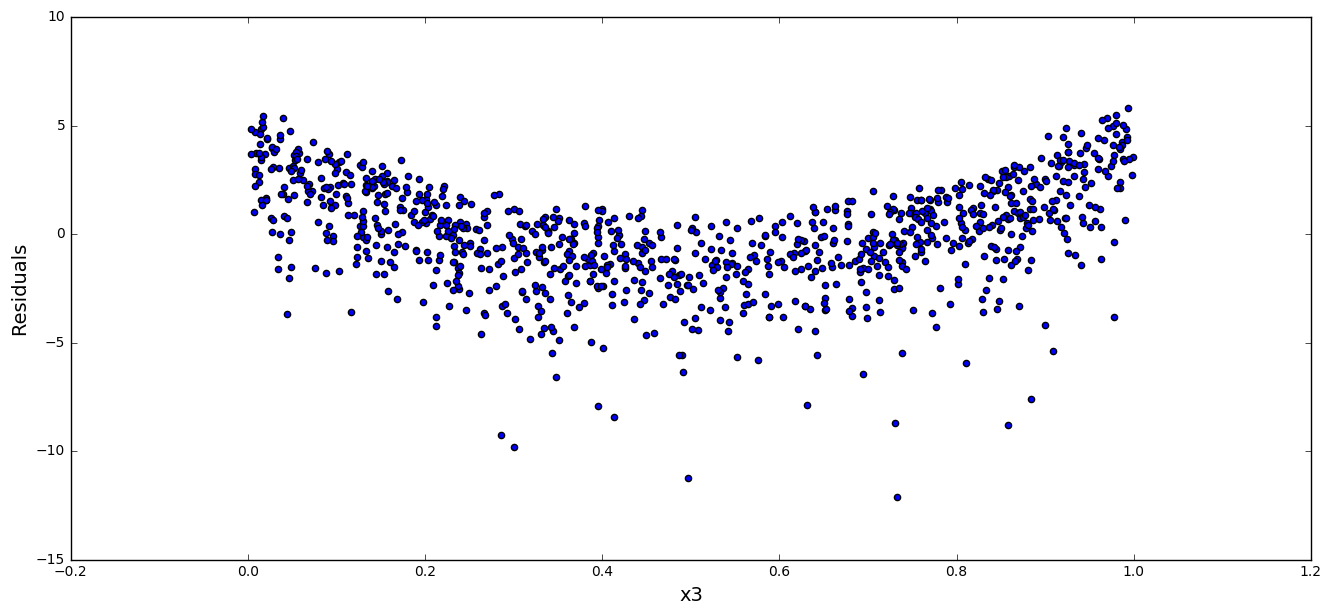

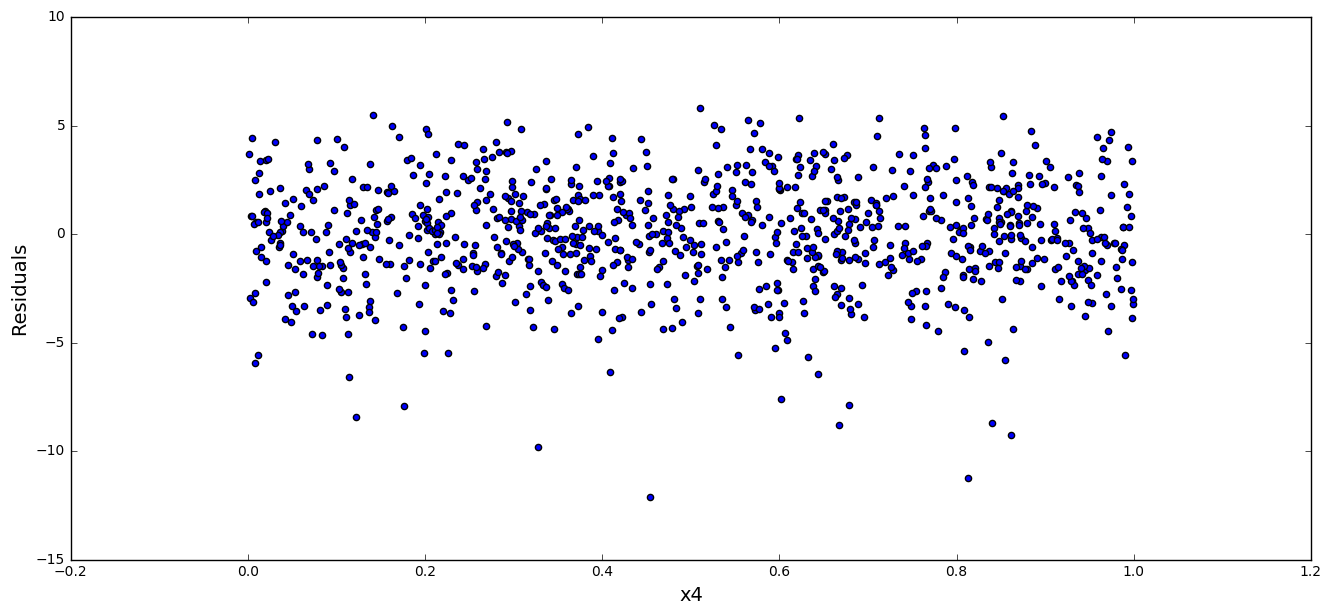

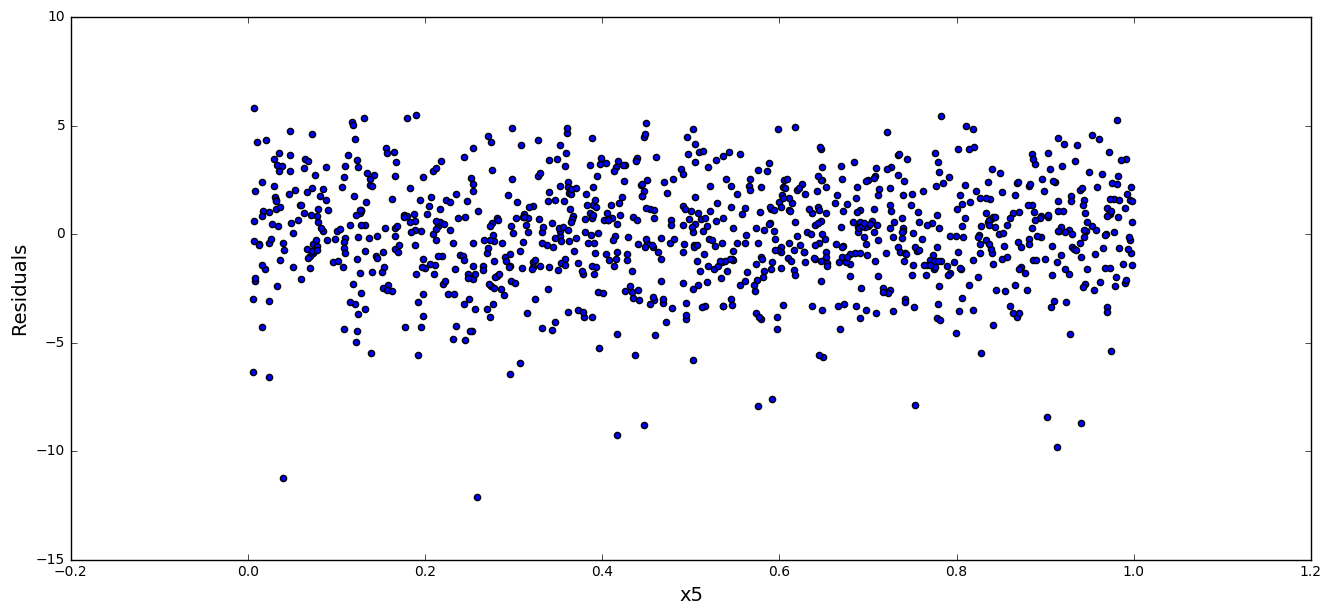

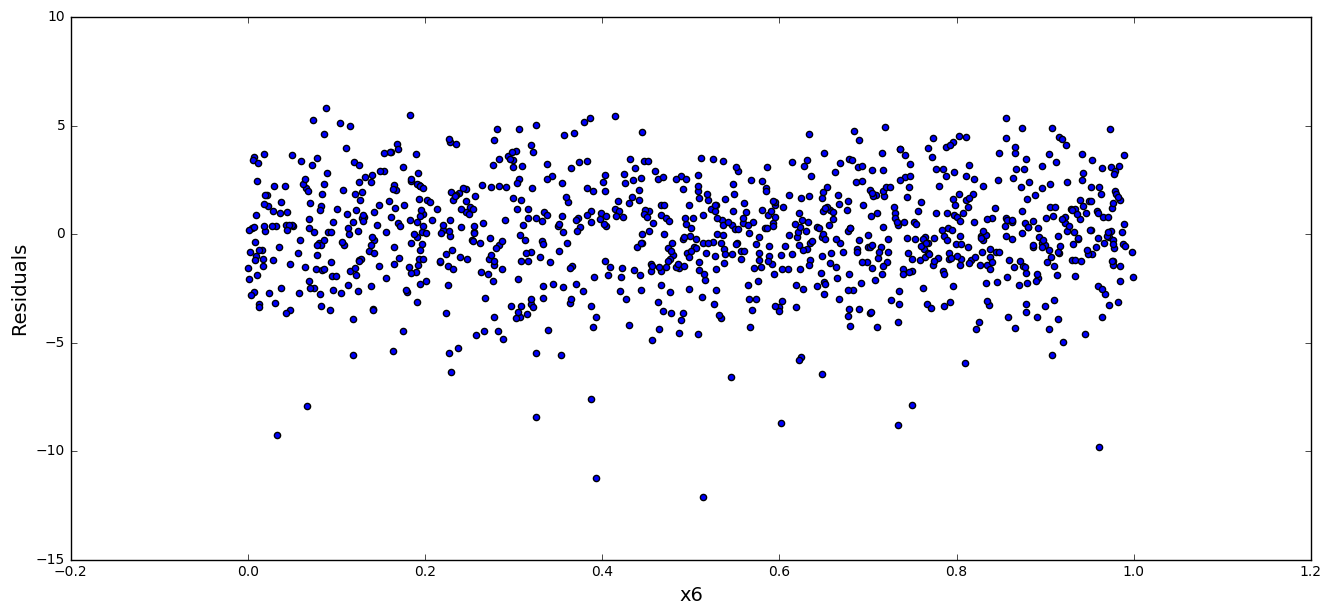

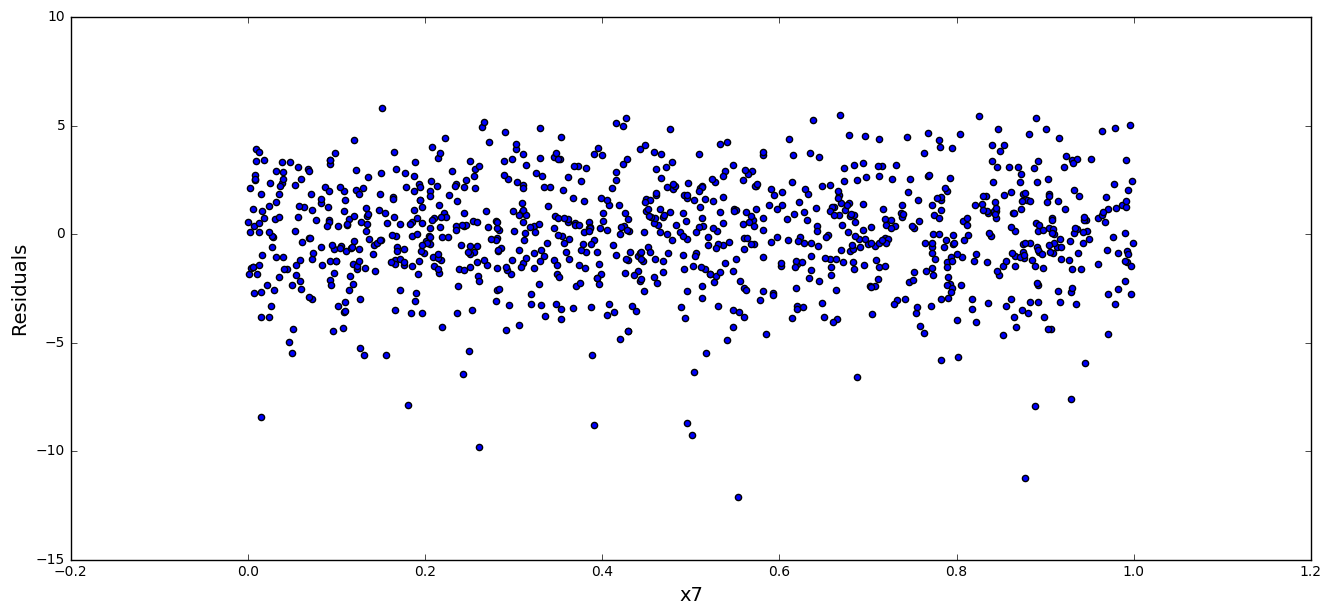

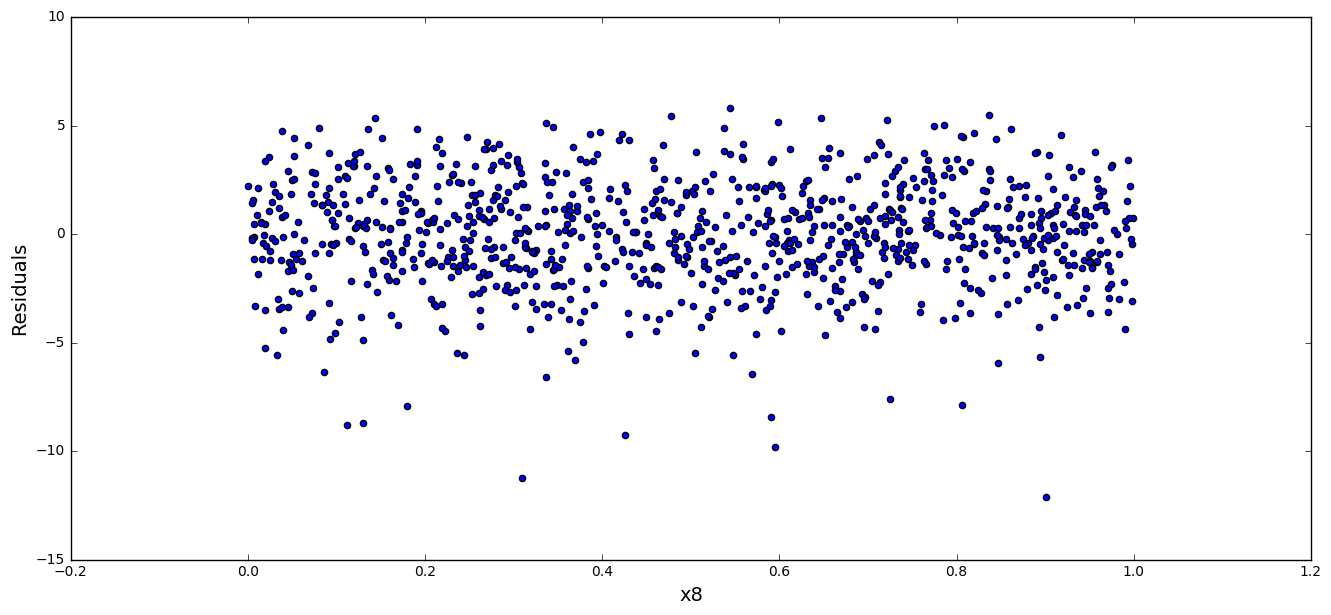

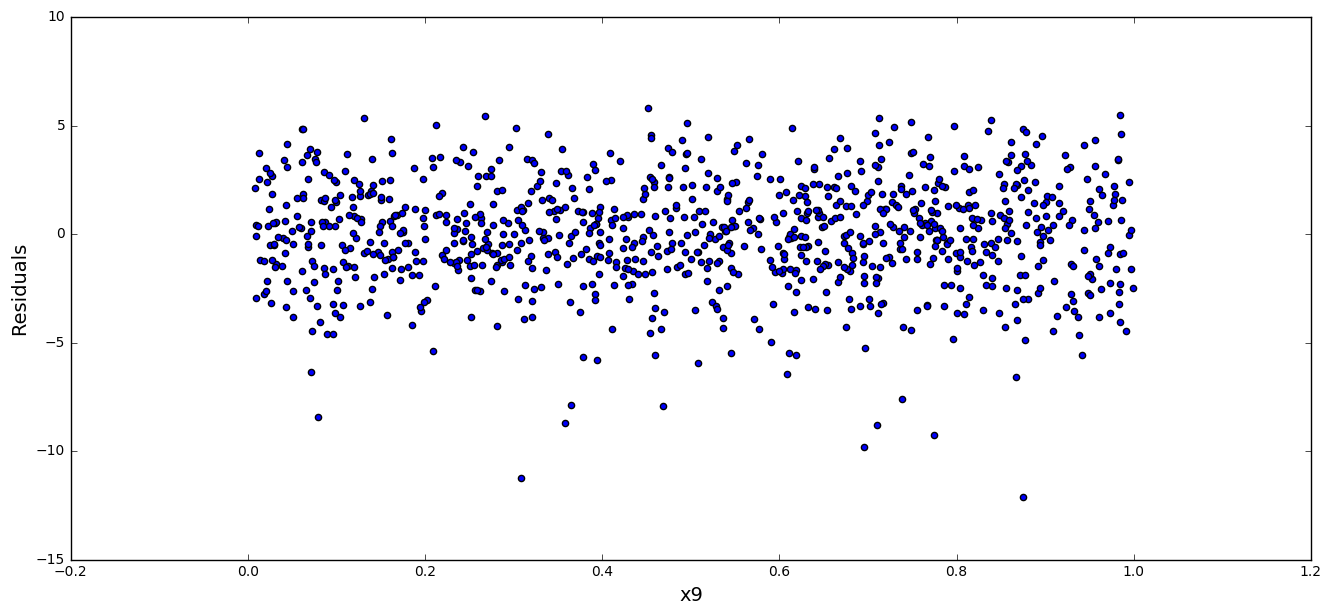

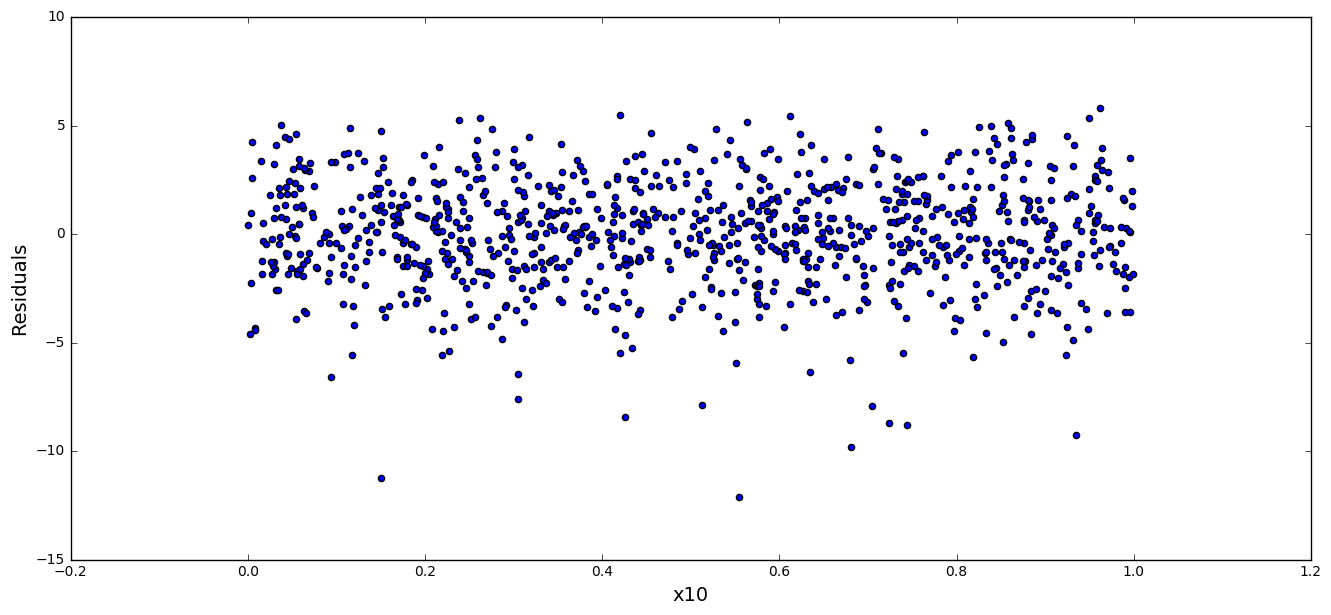

In [322]:
for col in cols_x:
    plt.figure(figsize(16,7))    
    scatter(data[col],fitted.resid)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Residuals', fontsize=14)

pylab.show()

#### В остатках регрессии на переменные x1, x2 и x3 видна квадратичная зависимость, введем соответствующие переменные в наше уравнение

### Модель №2: Модель с квадратами x1, x2 и x3.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     913.1
Date:                Thu, 16 Mar 2017   Prob (F-statistic):               0.00
Time:                        21:53:59   Log-Likelihood:                -1695.4
No. Observations:                 999   AIC:                             3419.
Df Residuals:                     985   BIC:                             3488.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0665      0.290     

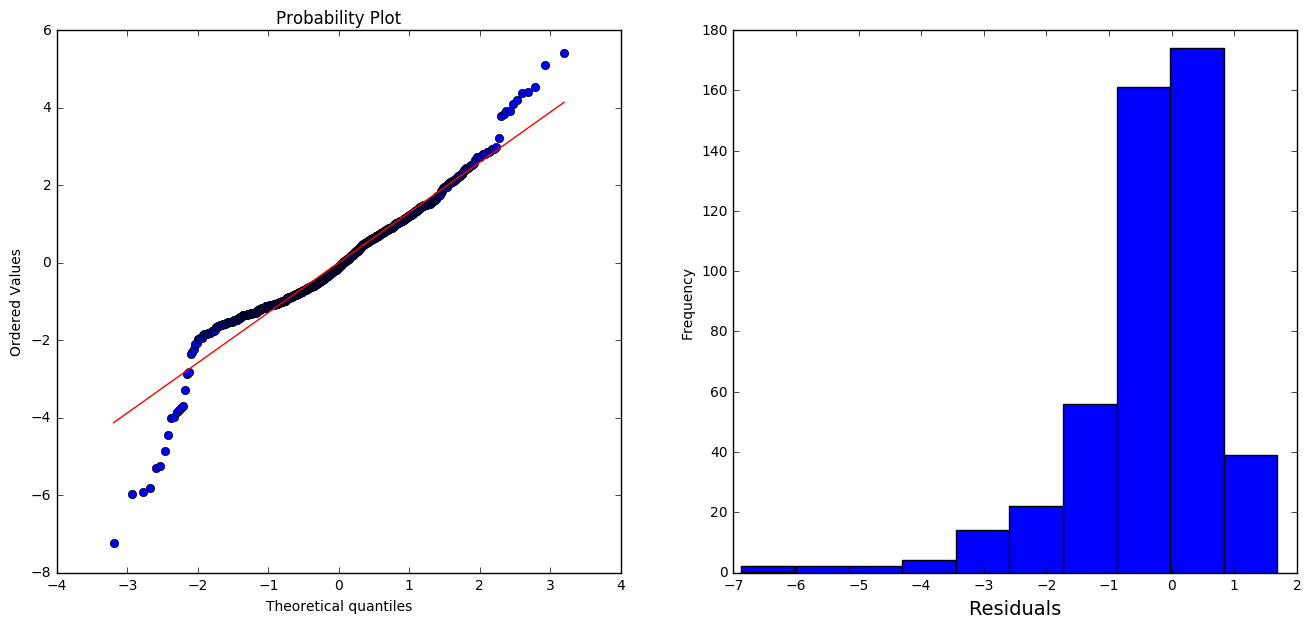

In [323]:
model2 = smf.ols('y ~ x1 + np.power(x1,2) + '\
                 'x2 + np.power(x2,2) + '\
                 'x3 + np.power(x3,2) + '\
                 'x4 + x5 + x6 +x7 + x8 + x9 + x10', data=data)
fitted = model2.fit()
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

#### Заметим, что R^2 довольно сильно возрос. Теперь наша модель объясняет 92,3% вариации целевой переменной y

In [324]:
print 'Breusch-Pagan test: p=%f' % sms.het_breushpagan(fitted.resid, fitted.model.exog)[1]

Breusch-Pagan test: p=0.000000


#### Ошибки все еще гетероскедастичны. Поищем еще зависимости в остатках.

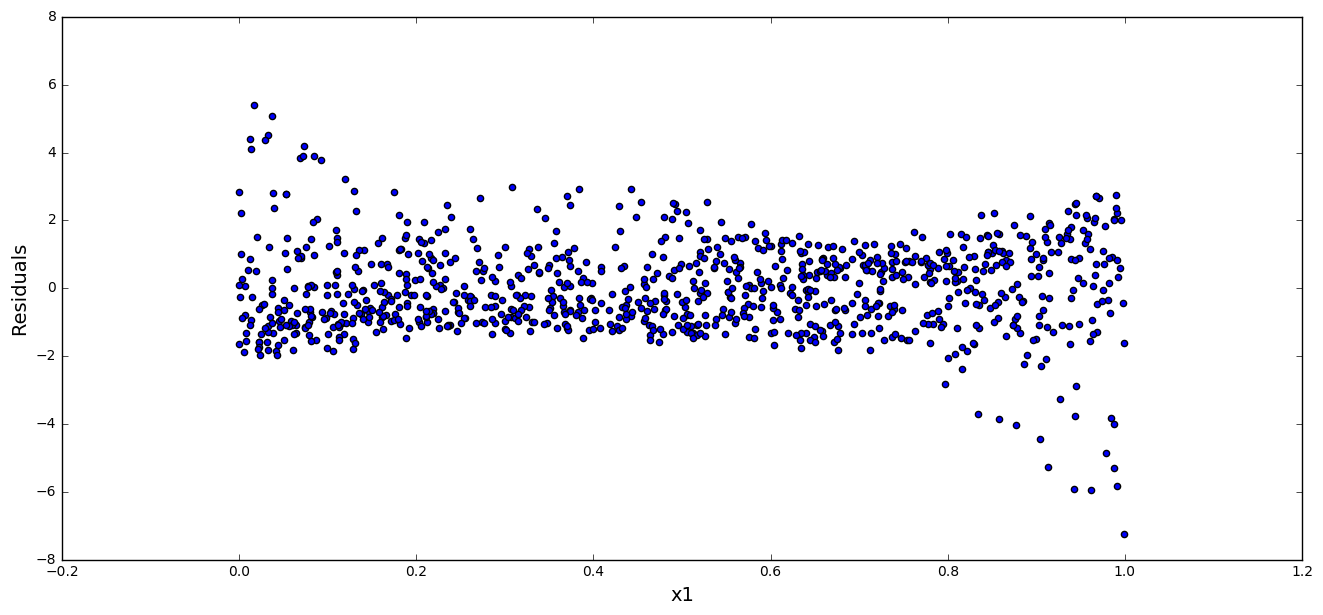

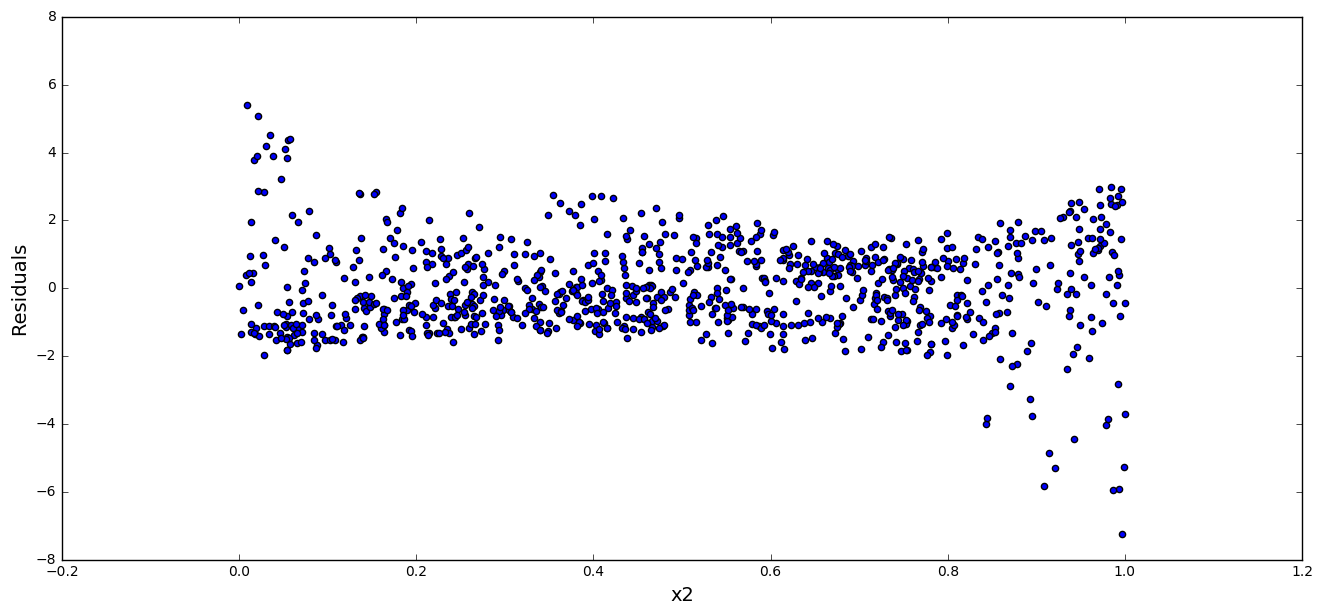

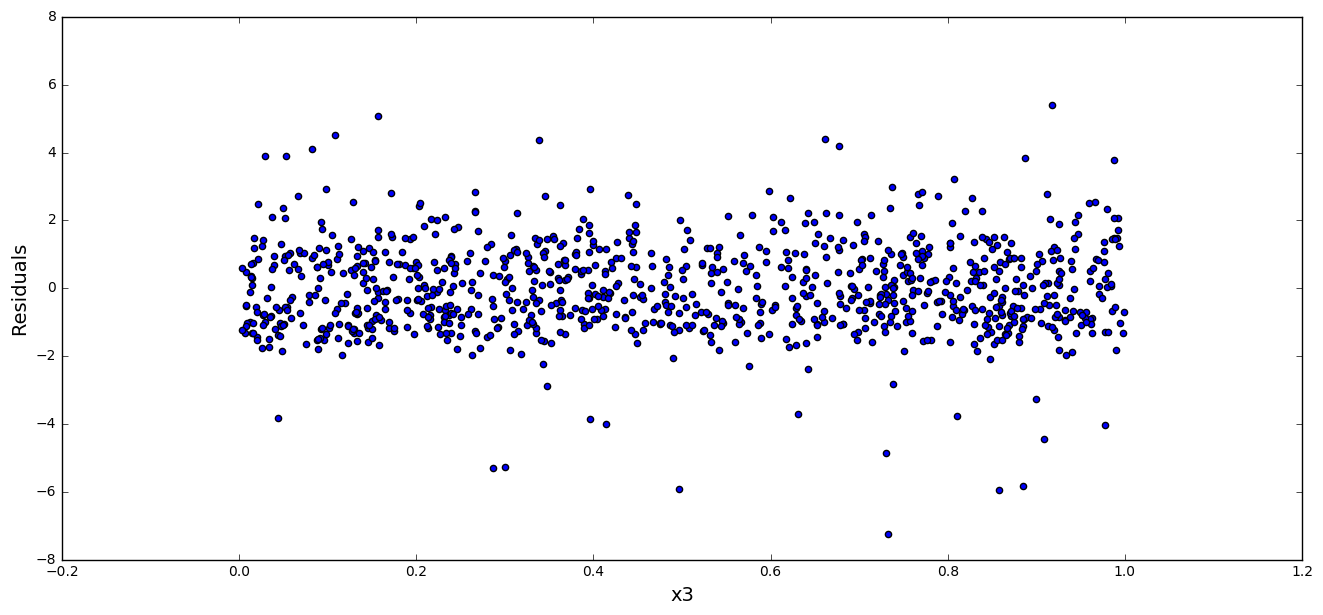

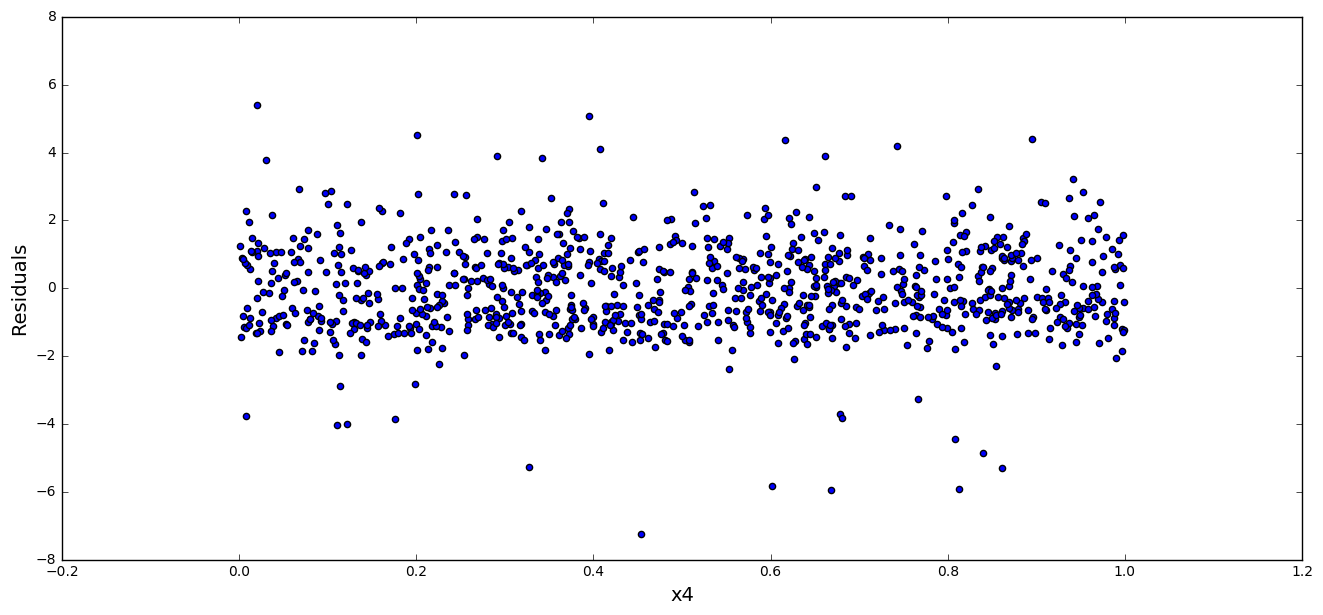

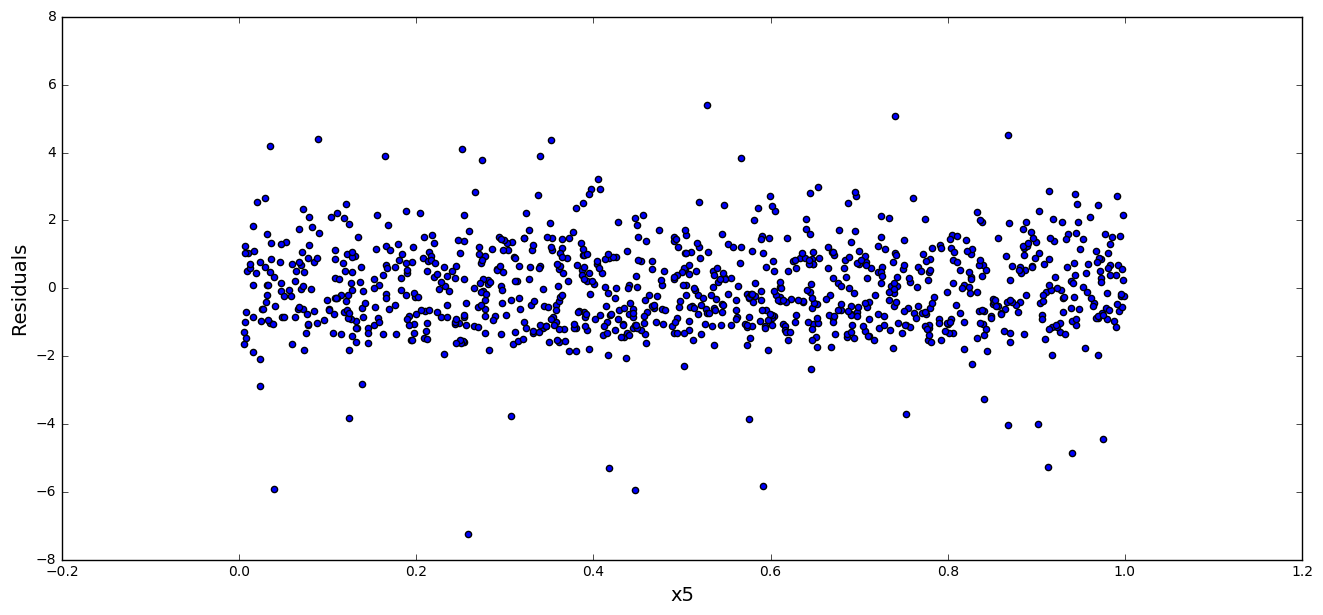

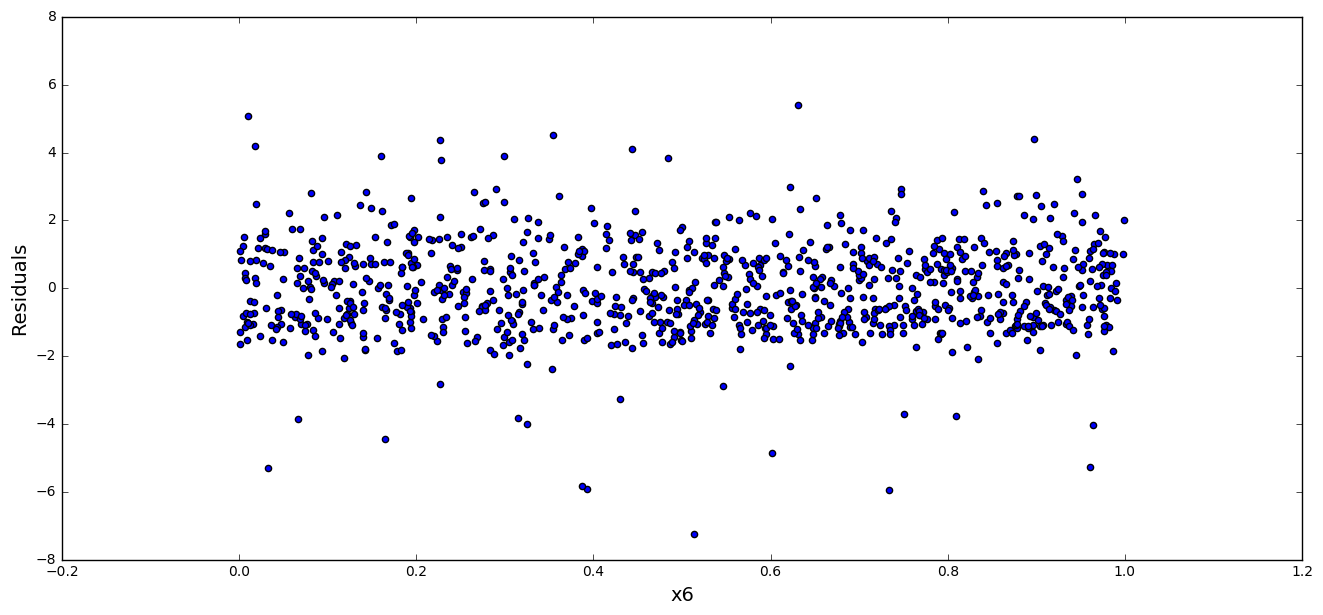

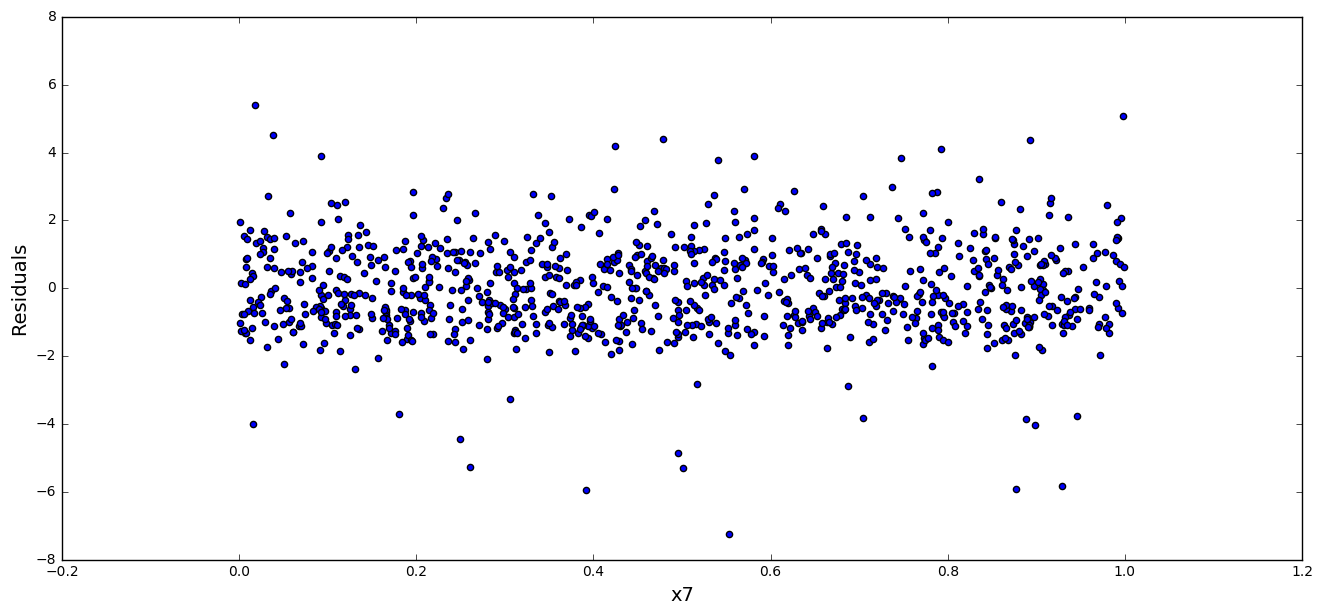

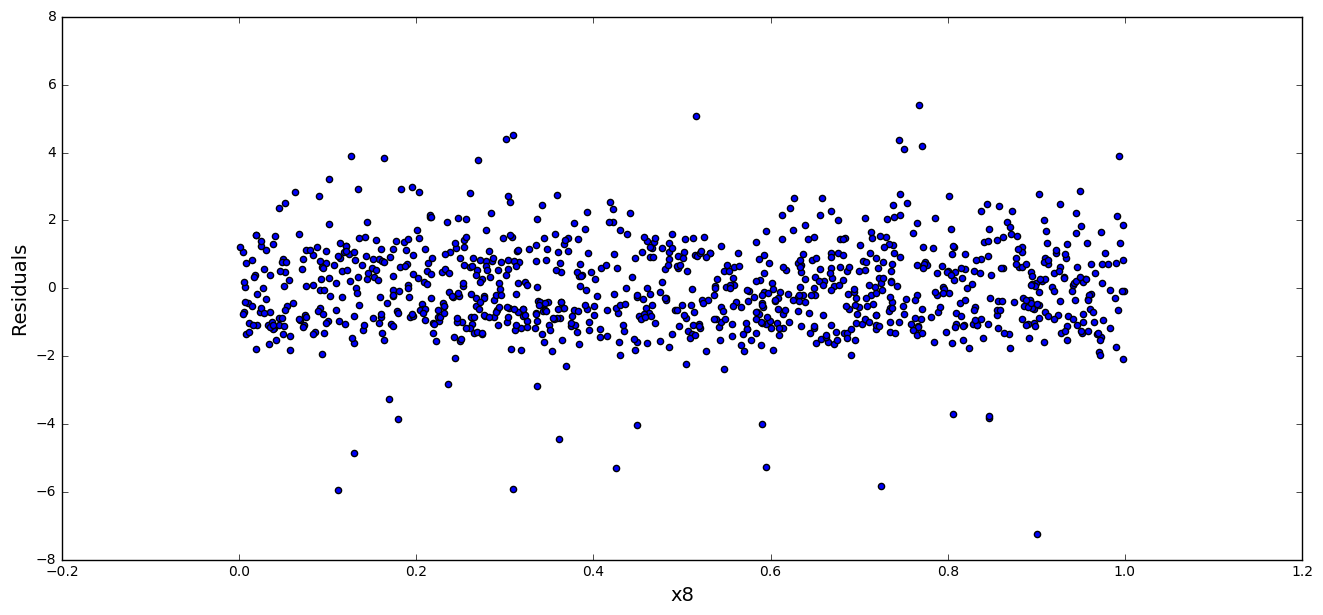

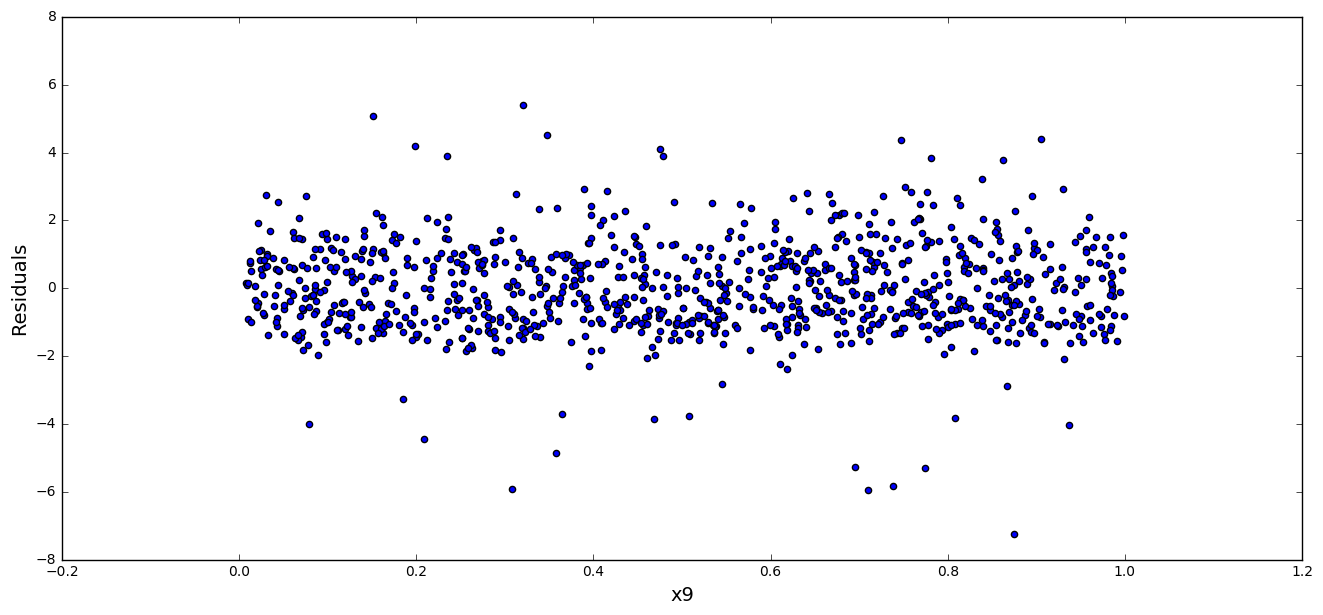

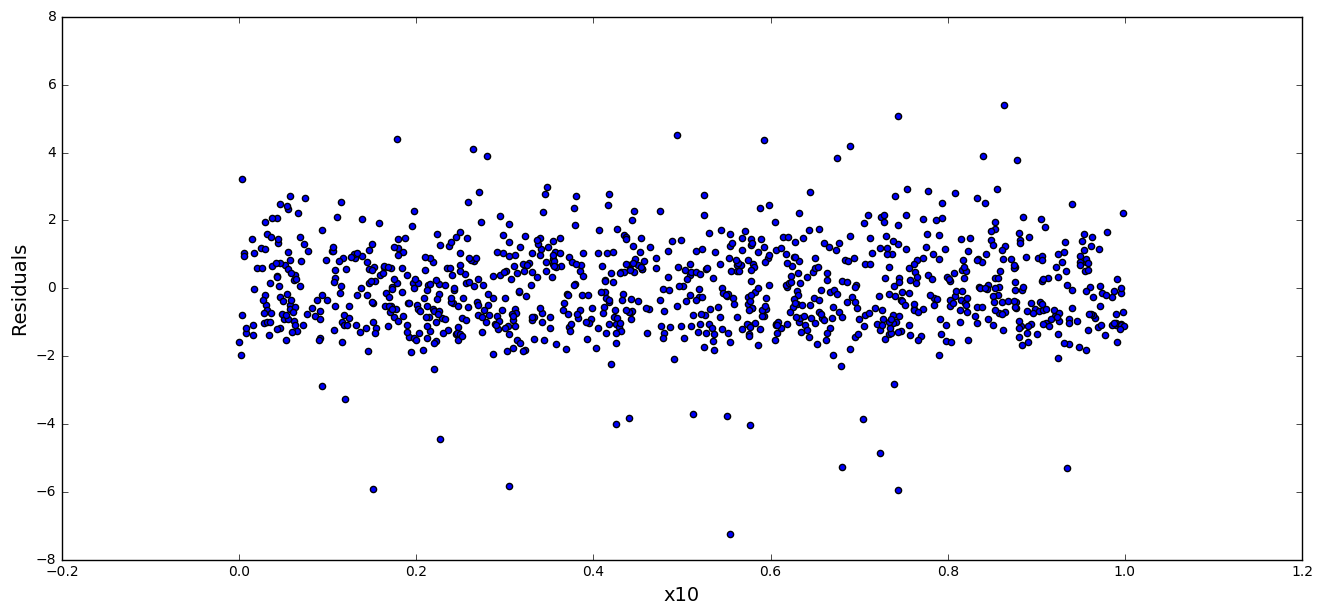

In [325]:
for col in cols_x:
    plt.figure(figsize(16,7))    
    scatter(data[col],fitted.resid)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Residuals', fontsize=14)

pylab.show()

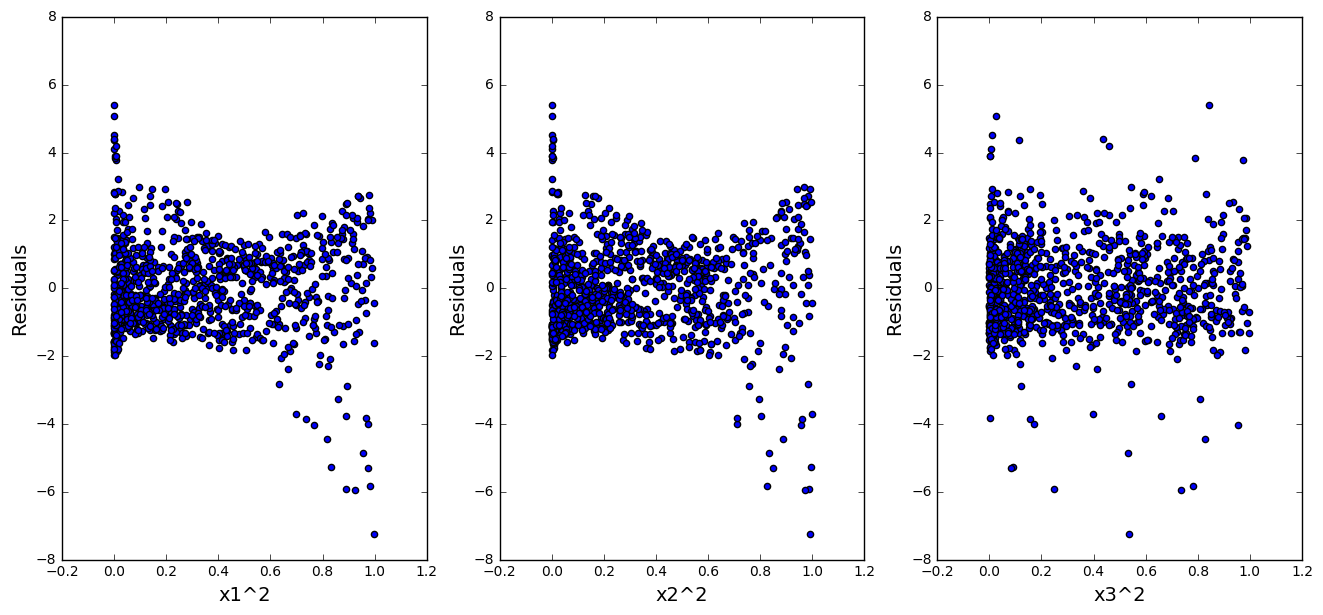

In [326]:
plt.subplot(131)
scatter(data['x1']**2,fitted.resid)
plt.xlabel('x1^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

plt.subplot(132)
scatter(data['x2']**2,fitted.resid)
plt.xlabel('x2^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

plt.subplot(133)
scatter(data['x3']**2,fitted.resid)
plt.xlabel('x3^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

pylab.show()

#### Исходя из графиков выше, на ум приходят 3 степени переменных x1 и x2. Введем их в модель.

### Модель №3: Добавим кубы x1 и x2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     791.7
Date:                Thu, 16 Mar 2017   Prob (F-statistic):               0.00
Time:                        21:54:04   Log-Likelihood:                -1694.3
No. Observations:                 999   AIC:                             3421.
Df Residuals:                     983   BIC:                             3499.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2814      0.323     

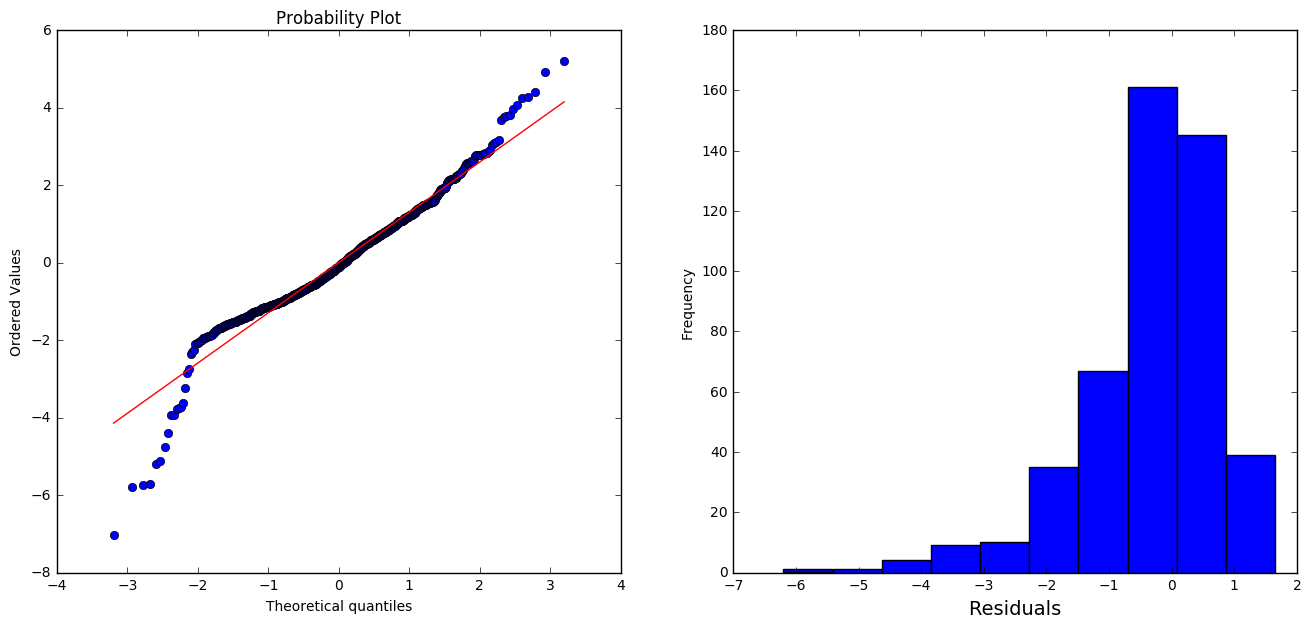

In [327]:
model3 = smf.ols('y ~         x1 + np.power(x1,2) + np.power(x1,3) + '\
                             'x2 + np.power(x2,2) + np.power(x2,3) + '\
                             'x3 + np.power(x3,2) + '\
                             'x4 + x5 + x6 +x7 + x8 + x9 + x10', data=data)
fitted = model3.fit()
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

In [328]:
print 'Breusch-Pagan test: p=%f' % sms.het_breushpagan(fitted.resid, fitted.model.exog)[1]

Breusch-Pagan test: p=0.000000


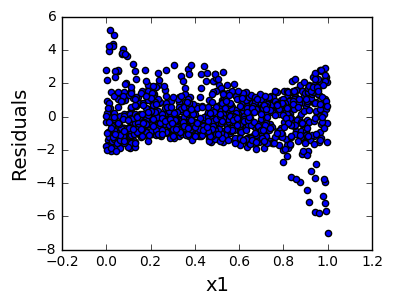

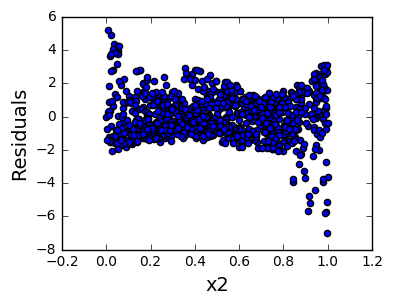

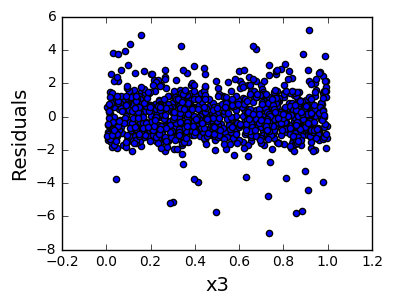

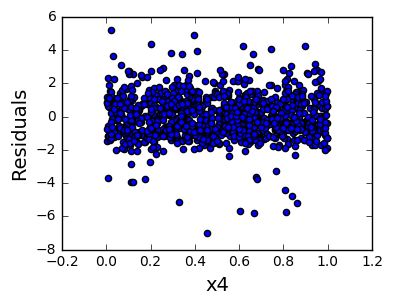

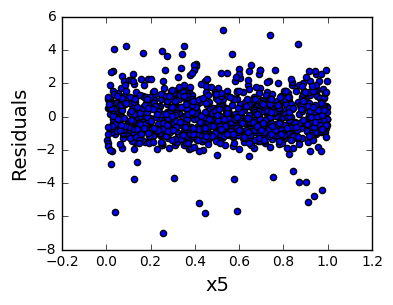

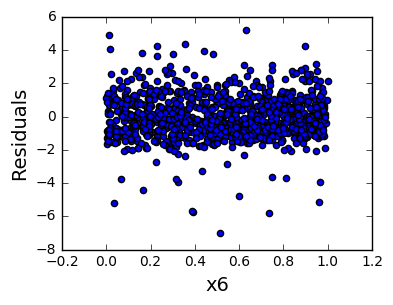

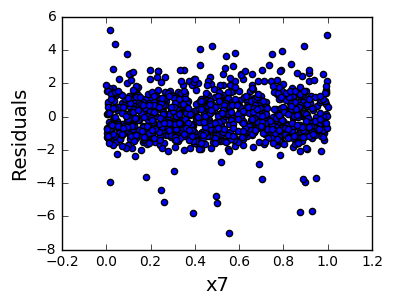

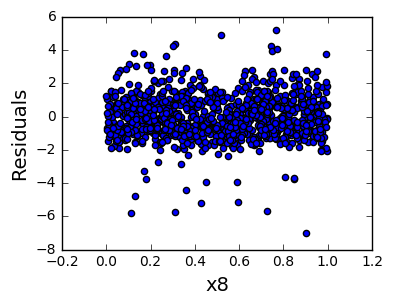

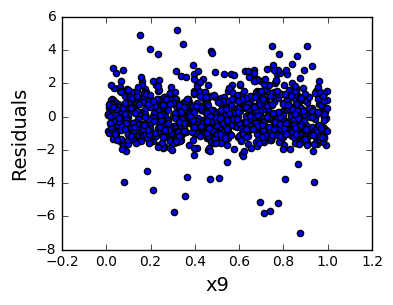

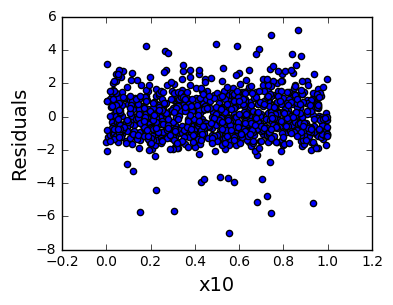

In [329]:
for col in cols_x:
    plt.figure(figsize(4,3))    
    scatter(data[col],fitted.resid)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Residuals', fontsize=14)

pylab.show()

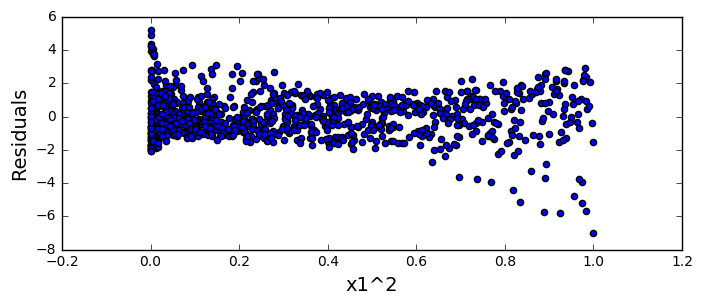

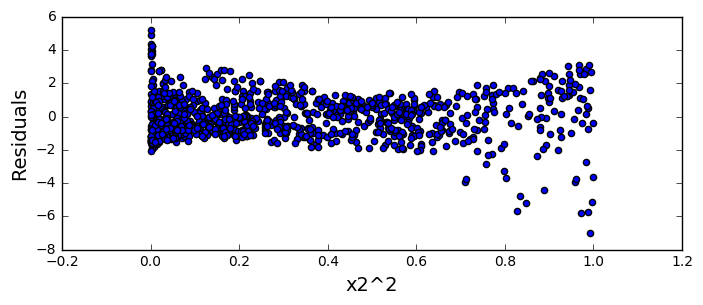

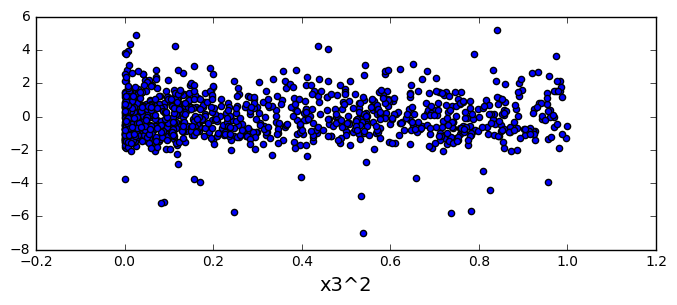

In [330]:
plt.figure(figsize(8,3))   
scatter(data['x1']**2,fitted.resid)
plt.xlabel('x1^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

plt.figure(figsize(8,3))
scatter(data['x2']**2,fitted.resid)
plt.xlabel('x2^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

plt.figure(figsize(8,3))
scatter(data['x3']**2,fitted.resid)
plt.xlabel('x3^2', fontsize=14)

pylab.show()

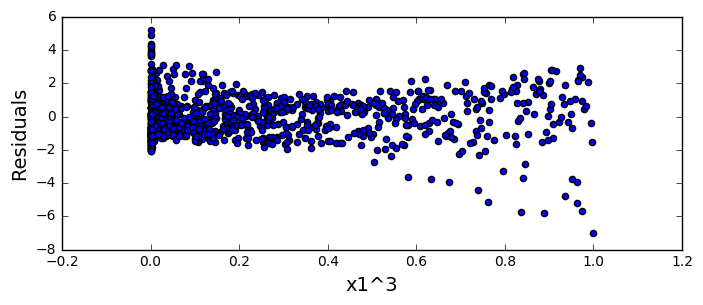

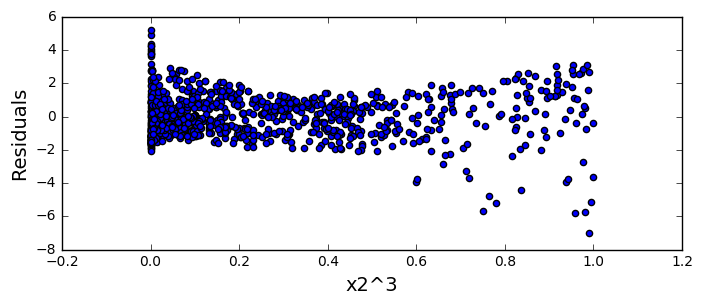

In [331]:
plt.figure(figsize(8,3))
scatter(data['x1']**3,fitted.resid)
plt.xlabel('x1^3', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

plt.figure(figsize(8,3))
scatter(data['x2']**3,fitted.resid)
plt.xlabel('x2^3', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

pylab.show()

#### Похоже кубы x1 и x2 не добавили нам ничего интересного в нашу модель. Сравним формально две модели (с кубами и без).

In [332]:
print "F=%f, p=%f, k1=%f" % model3.fit().compare_f_test(model2.fit())

F=1.139699, p=0.320338, k1=2.000000


#### p-value = 0.320338>0.05 (и даже 0.10). Следовательно модель не стала хуже от удаления кубов переменных. Не можем отвергнуть гипотезу о том, что эти переменные играли существенную роль в модели.

#### Так как в модели №3 ошибки были гетероскедастичны, то сделаем поправку Уайта на гетероскедастичность. После этого можно будет интерпретировать модель.

### Модель №4: Модель с поравкой Уайта на гетероскедастичность

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     726.1
Date:                Thu, 16 Mar 2017   Prob (F-statistic):               0.00
Time:                        21:54:07   Log-Likelihood:                -1695.4
No. Observations:                 999   AIC:                             3419.
Df Residuals:                     985   BIC:                             3488.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0665      0.379     

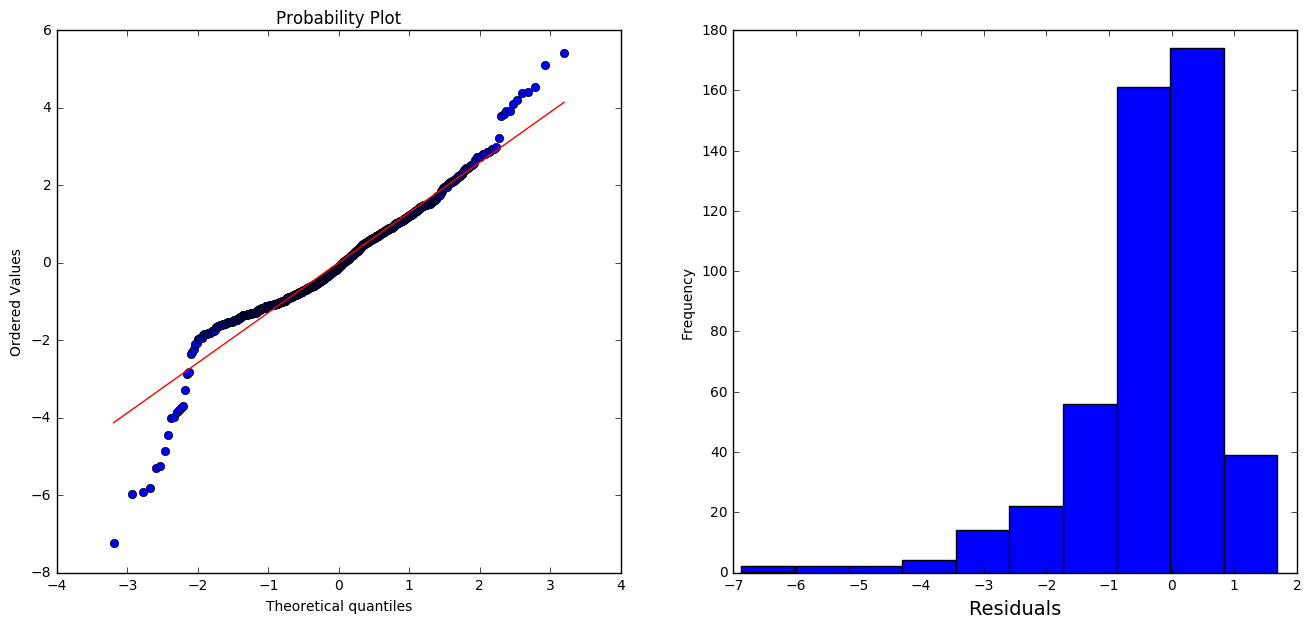

In [333]:
model5 = smf.ols('y ~         x1 + np.power(x1,2) + '\
                             'x2 + np.power(x2,2) + '\
                             'x3 + np.power(x3,2) + '\
                             'x4 + x5 + x6 + x7 + x8 + x9 + x10', data=data)

fitted = model5.fit(cov_type='HC1') # Поправка
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

### Проведем еще один анализ:

####  Построим график так называемой "влиятельности" точек. Так как регрессия склонна перенастраиваться на нетипичные наблюдения (лежащие далеко от основного облака). Посмотрим, есть ли такие точки в наших данных.

#### По горизонтальной оси отложены квадраты остатков для каждого из наблюдений, по вертикальной - "влиятельность" наблюдения. Чем значение по вертикали больше, тем больше данное наблюдение влияет на регрессионное уравнение

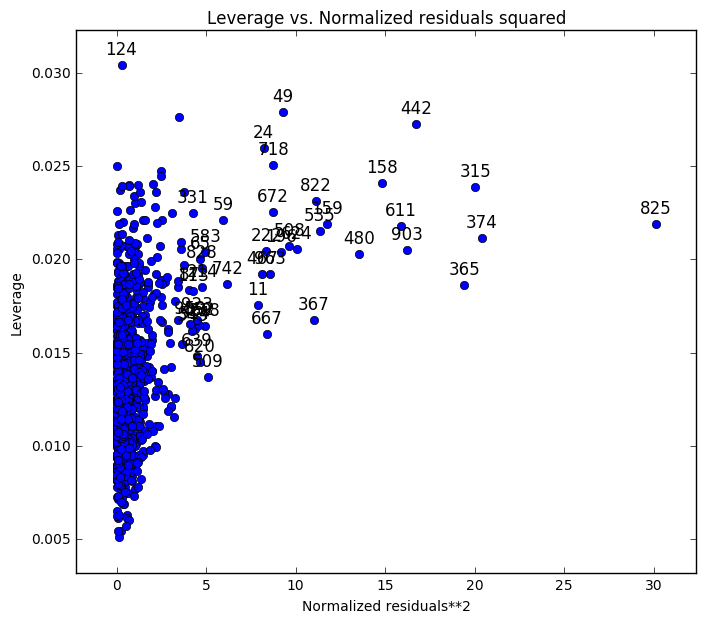

In [334]:
plt.figure(figsize(8,7))
plot_leverage_resid2(fitted)
pylab.show()

#### По большому счету, нам ничего не мешает посмотреть на некоторые из точек (наблюдений), лежащие относительно далеко от основного облака.

In [335]:
outliers = [442, 825, 315, 374, 365, 611, 903, 158, 480, 159, 49, 24]
data.loc[outliers] 

x1        x2        x3        x4        x5        x6        x7  \
442  0.016896  0.008616  0.917199  0.019932  0.527991  0.630763  0.017754   
825  0.999566  0.996334  0.733110  0.454163  0.258034  0.513659  0.552643   
315  0.942557  0.993377  0.497164  0.812538  0.039043  0.392478  0.877054   
374  0.961611  0.986311  0.858356  0.667767  0.447309  0.733342  0.391083   
365  0.991649  0.909205  0.884525  0.602088  0.591063  0.387372  0.929342   
611  0.913343  0.998494  0.299912  0.327049  0.912918  0.960736  0.261154   
903  0.987303  0.920745  0.286156  0.861803  0.417110  0.032937  0.500788   
158  0.037002  0.021193  0.157209  0.394476  0.740371  0.010138  0.997911   
480  0.978263  0.913940  0.730686  0.839548  0.940176  0.601591  0.495537   
159  0.032394  0.034413  0.107700  0.200507  0.867865  0.354277  0.038481   
49   0.876944  0.978817  0.977666  0.110384  0.868281  0.963893  0.899110   
24   0.092655  0.016588  0.987178  0.030686  0.274586  0.227928  0.540886   

           x8        x9       x10   y  
442  0.768062  0.320301  0.863760   7  
825  0.901038  0.875299  0.553973   8  
315  0.308788  0.307857  0.150693  11  
374  0.111948  0.710560  0.744320  14  
365  0.725178  0.737857  0.305207  15  
611  0.594454  0.695882  0.681125  12  
903  0.425522  0.774500  0.935233  15  
158  0.515969  0.151368  0.743644  11  
480  0.130095  0.357591  0.723635  18  
159  0.309612  0.347279  0.494173  10  
49   0.448905  0.936853  0.576564  15  
24   0.269530  0.861927  0.877840   7

In [336]:
data.shape[0]

999

#### Если бы данные несли нам хоть какую-то информацию о переменных, то возможно в этих наблюдениях мы бы заметили какие-то отклонения от нормального поведения. Попробуем их удалить, ведь от удаления 12 наблюдений по сути ничего не изменится (~1.2% От всех данных), но R^2 может существенно подрости.

In [337]:
data = data.drop(data.index[outliers])

#### Также заметим, что в предыдущей модели у нас есть незначимые переменные: Intercept и x6-x10, удалим их из модели.

### Модель №5: Модель без части наблюдений (нетипичных) и без незначимых переменных (x6-x10)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.497e+04
Date:                Thu, 16 Mar 2017   Prob (F-statistic):               0.00
Time:                        21:54:08   Log-Likelihood:                -1562.8
No. Observations:                 987   AIC:                             3142.
Df Residuals:                     979   BIC:                             3181.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
x1                 18.7545      0.490     

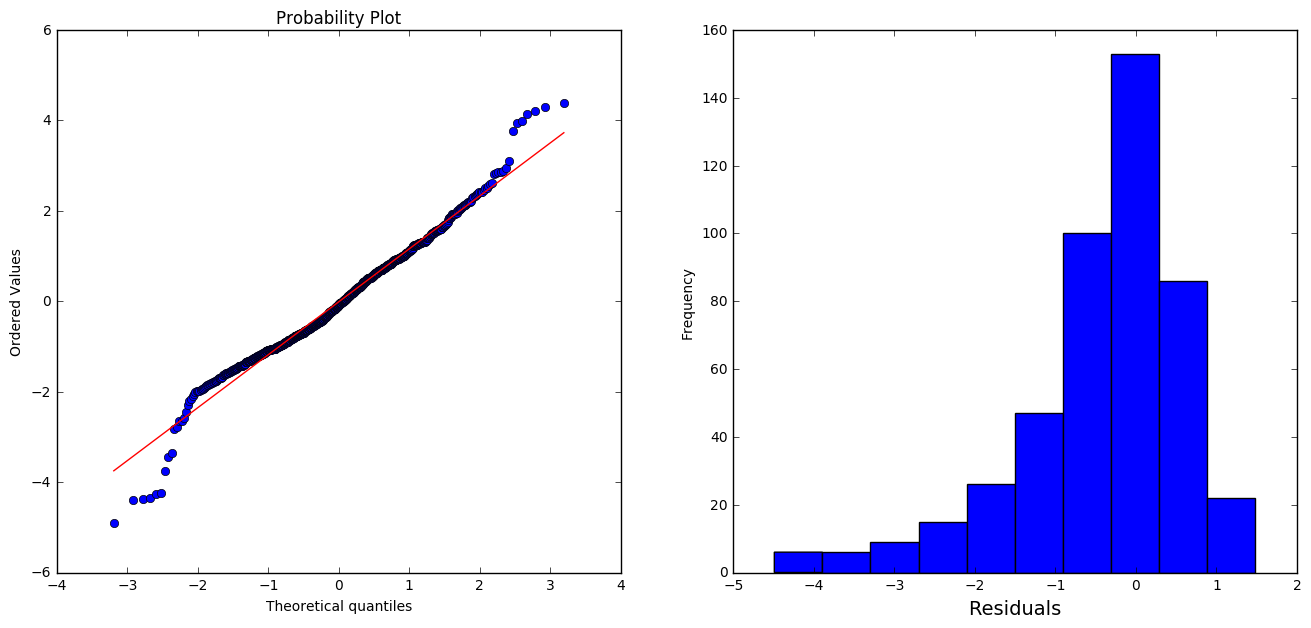

In [338]:
model5 = smf.ols('y ~ 0 + x1 + np.power(x1,2) + '\
                 'x2 + np.power(x2,2) + '\
                 'x3 + np.power(x3,2) + '\
                 'x4 + x5', data=data)

fitted = model5.fit(cov_type='HC1')
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

#### Действительно, заметим, что теперь мы объясняем почти 99.4(!)% вариации целевой переменной. Это очень хороший результат.

### Выводы

#### Итак:
    1) Построенная выше модель объясняет 99.4% вариации целевой переменной
    2) Критерий точности был выбран R^2. Исходя из него, 
        "Важные" для модели переменные: x1-x5 (а также квадраты x1 и x2),
        "Неважные" - остальные: x6-x10